In [1]:
using CSV, DataFrames
using PyCall
using CairoMakie

include("./src/cubes.jl")
include("./src/network.jl")

@pyimport powerlaw as powlaw

In [2]:
region = "Italy"
magnitude_threshold = 0.0 
cell_sizes = [5.0];
multiplier = [1.0];

# Read data
path = "./data/"
filepath = path * region * ".csv"
df = CSV.read(filepath, DataFrame);
df = df[df.Magnitude .> magnitude_threshold,:];

# Make path for results
mkpath("./results/$region")

"./results/Italy"

Calculating best minimal value for power law fit


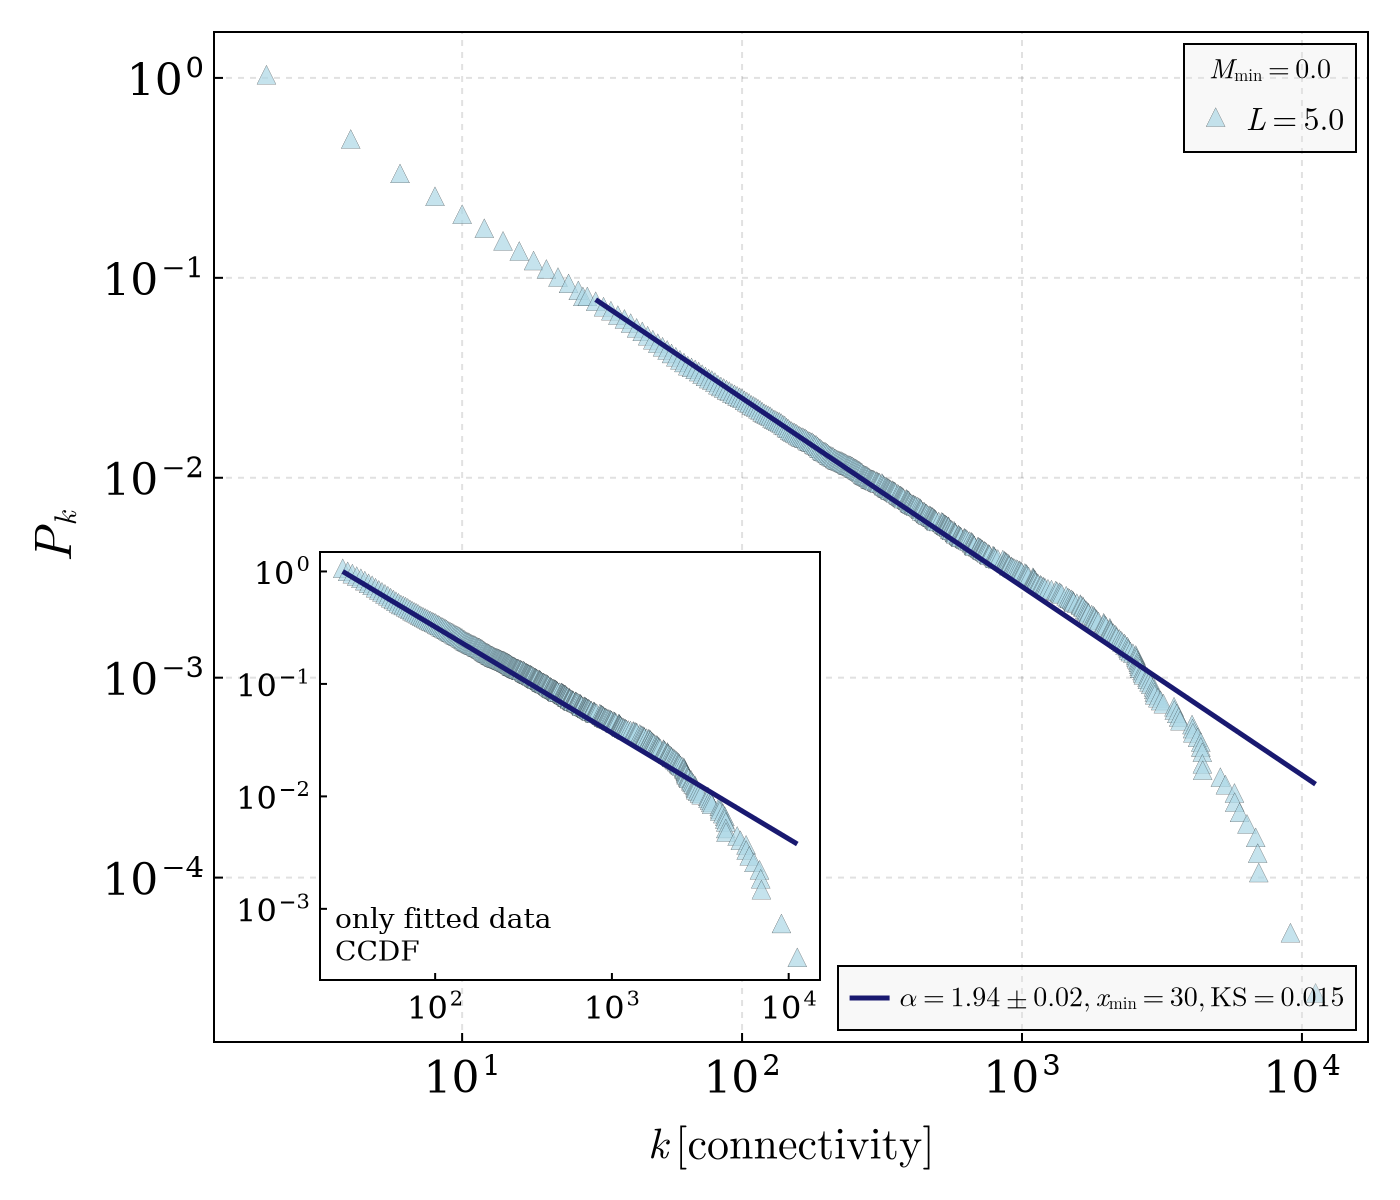

In [13]:
set_theme!(Theme(fonts=(; regular="CMU Serif")))
fig = Figure(size = (700, 600), font= "CMU Serif") 
ax1 = Axis(fig[1, 1], xlabel = L"k\,[\text{connectivity}]", ylabel = L"P_k", xscale=log10, yscale=log10, ylabelsize = 26,
    xlabelsize = 22, xgridstyle = :dash, ygridstyle = :dash, xtickalign = 1,
    xticksize = 5, ytickalign = 1, yticksize = 5 , xlabelpadding = 10, ylabelpadding = 10,xticklabelsize=22, yticklabelsize=22)

########################################## TRUNCATED
ax2 = Axis(fig, bbox = BBox(160,410,110,324), xscale=log10, yscale=log10, xgridvisible = false, ygridvisible = false, xtickalign = 1,
xticksize = 4, ytickalign = 1, yticksize = 4, xticklabelsize=16, yticklabelsize=16, backgroundcolor=:white)

markers=[:utriangle, :diamond, :circle]
colors=[:lightblue, :lightgreen, :lightsalmon]
line_colors=[:midnightblue, :green, :darkred]

sc1 = Array{Any,1}(undef,3)

for i in eachindex(cell_sizes)
    df, df_cubes = region_cube_split(df,cell_size=cell_sizes[i])
    MG = create_network(df, df_cubes)
    degrees=[]
    for i in 1:nv(MG)
        push!(degrees, get_prop(MG, i, :degree))
    end

    # Powerlaw Fit
    fit = powlaw.Fit(degrees);
    alpha = round(fit.alpha, digits=2)
    sigma = round(fit.sigma, digits=2)
    xmin = Int(round(fit.xmin, digits=2))
    KS = round(fit.power_law.KS(data=degrees), digits=3)

    # CCDF of truncated data (fitted), x and y values
    x_ccdf, y_ccdf = fit.ccdf()

    # The fit (from theoretical power_law)
    fit_power_law = fit.power_law.plot_ccdf()[:lines][1]
    x_powlaw, y_powlaw = fit_power_law[:get_xdata](), fit_power_law[:get_ydata]()

    ########################################### ALL
    # CCDF of all data scattered 
    x_ccdf_original_data, y_ccdf_original_data = powlaw.ccdf(degrees)

    sc1[i] = scatter!(ax1, multiplier[i] .* x_ccdf_original_data, y_ccdf_original_data,
        color=(colors[i], 0.7), strokewidth=0.1, marker=markers[i], markersize=13)

    # Fit through truncated data
    # Must shift the y values from the theoretical powerlaw by the values of y of original data, but cut to the length of truncated data
    ln = lines!(ax1, multiplier[i] .* x_powlaw, y_ccdf_original_data[end-length(x_ccdf)] .* y_powlaw, label= L"\alpha=%$(alpha) \pm %$(sigma),\, x_{\mathrm{min}}=%$(xmin),\, \mathrm{KS}=%$(KS)",
    color=line_colors[i], linewidth=2.5, strokewidth=5) 


    ########################################### TRUNCATED
    # CCDF of truncated data (fitted), the plot, (re-normed)
    scatter!(ax2, multiplier[i] .* x_ccdf, y_ccdf,
        color=(colors[i], 0.7), strokewidth=0.1, marker=markers[i], markersize=13)

    # Fit through truncated data (re-normed)
    lines!(ax2, multiplier[i] .* x_powlaw, y_powlaw,
            color=line_colors[i], linewidth=2.5) 

end


text!(ax2, "only fitted data\nCCDF", space = :relative, position = Point2f(0.03, 0.03))

translate!(ax2.elements[:background], 0, 0, 9)
translate!(ax2.scene, 0, 0, 10)


# Top right, cell size legend
axislegend(ax1, [sc1[i] for i in eachindex(cell_sizes)], [L"L=%$(cell_sizes[i])" for i in eachindex(cell_sizes)], L"M_{\min}=%$(magnitude_threshold)", position = :rt, backgroundcolor = (:grey90, 0.25), labelsize=16);
# Bottom left, results legend
axislegend(ax1, position = :rb, backgroundcolor = (:grey90, 0.25), labelsize=14);




# Save plot
# save( "./results/$region/$(region)_mag_$(magnitude_threshold)_best_fits.png", fig, px_per_unit=7)
# save( "./results/$region/$(region)_mag_$(magnitude_threshold)_best_fits.pdf", fig)
save( "./results/$region/$(region)_mag_$(magnitude_threshold)_cell_size_5.0_mle.png", fig, px_per_unit=7)
fig


In [6]:
# path = "./data/"
# name = "Italy"
# filepath = path * name * ".csv"

# italy_full = CSV.read(filepath, DataFrame);

# italy = italy_full[(italy_full.Depth .>= 0.0),:];

# df, df_cubes = region_cube_split(italy,cell_size=5.0)
# MG = create_network(df, df_cubes)
# degrees=[]
# for i in 1:nv(MG)
#     push!(degrees, get_prop(MG, i, :degree))
# end

# # italy, italy_cubes = region_cube_split(italy,side=10,energyRelease=false);

# # MG = create_network(italy, italy_cubes; edgeWeight=false)
# # connectivity = degree(MG);
# degrees=[]
# indegrees=[]
# outdegrees=[]
# for i in 1:nv(MG)
#     push!(degrees, get_prop(MG, i, :degree))
#     push!(indegrees, get_prop(MG, i, :indegree))
#     push!(outdegrees, get_prop(MG, i, :outdegree))
# end